In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

from keras.optimizers import Adam
import keras.backend as K


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                image                   id  \
522                    ../data/Train/CameraRGB/16.png                   16   
2493  ../data/Train/CameraRGB/episode_0004_000048.png  episode_0004_000048   
1324  ../data/Train/CameraRGB/episode_0002_000138.png  episode_0002_000138   
961   ../data/Train/CameraRGB/episode_0001_000047.png  episode_0001_000047   
2124                  ../data/Train/CameraRGB/230.png                  230   

                                                label  
522                    ../data/Train/CameraSeg/16.png  
2493  ../data/Train/CameraSeg/episode_0004_000048.png  
1324  ../data/Train/CameraSeg/episode_0002_000138.png  
961   ../data/Train/CameraSeg/episode_0001_000047.png  
2124                  ../data/Train/CameraSeg/230.png  


In [4]:
from models.unet import model_unet
from models.fcn8 import model_fcn8

model = model_fcn8(3, image_shape=(480, 480, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [5]:
from gen.generators import train_and_lab_gen_func

BATCH_SIZE = 16
model_dir = '../saved_models/unet/'

train_gen = train_and_lab_gen_func(train_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
# test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE)

In [6]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


In [7]:
from train import jaccard_distance_loss
from keras.optimizers import SGD, rmsprop

# opt =SGD(lr=1, momentum=0.01, decay=0.001, nesterov=False)
opt = rmsprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
weights = np.array([10, 5, 1])
model.compile(loss=weighted_categorical_crossentropy(weights),
              optimizer='adam',
              metrics=['accuracy'])

# model.compile(optimizer = opt, 
#                    loss = jaccard_distance_loss,
#                    metrics = ['acc'])


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2500 images


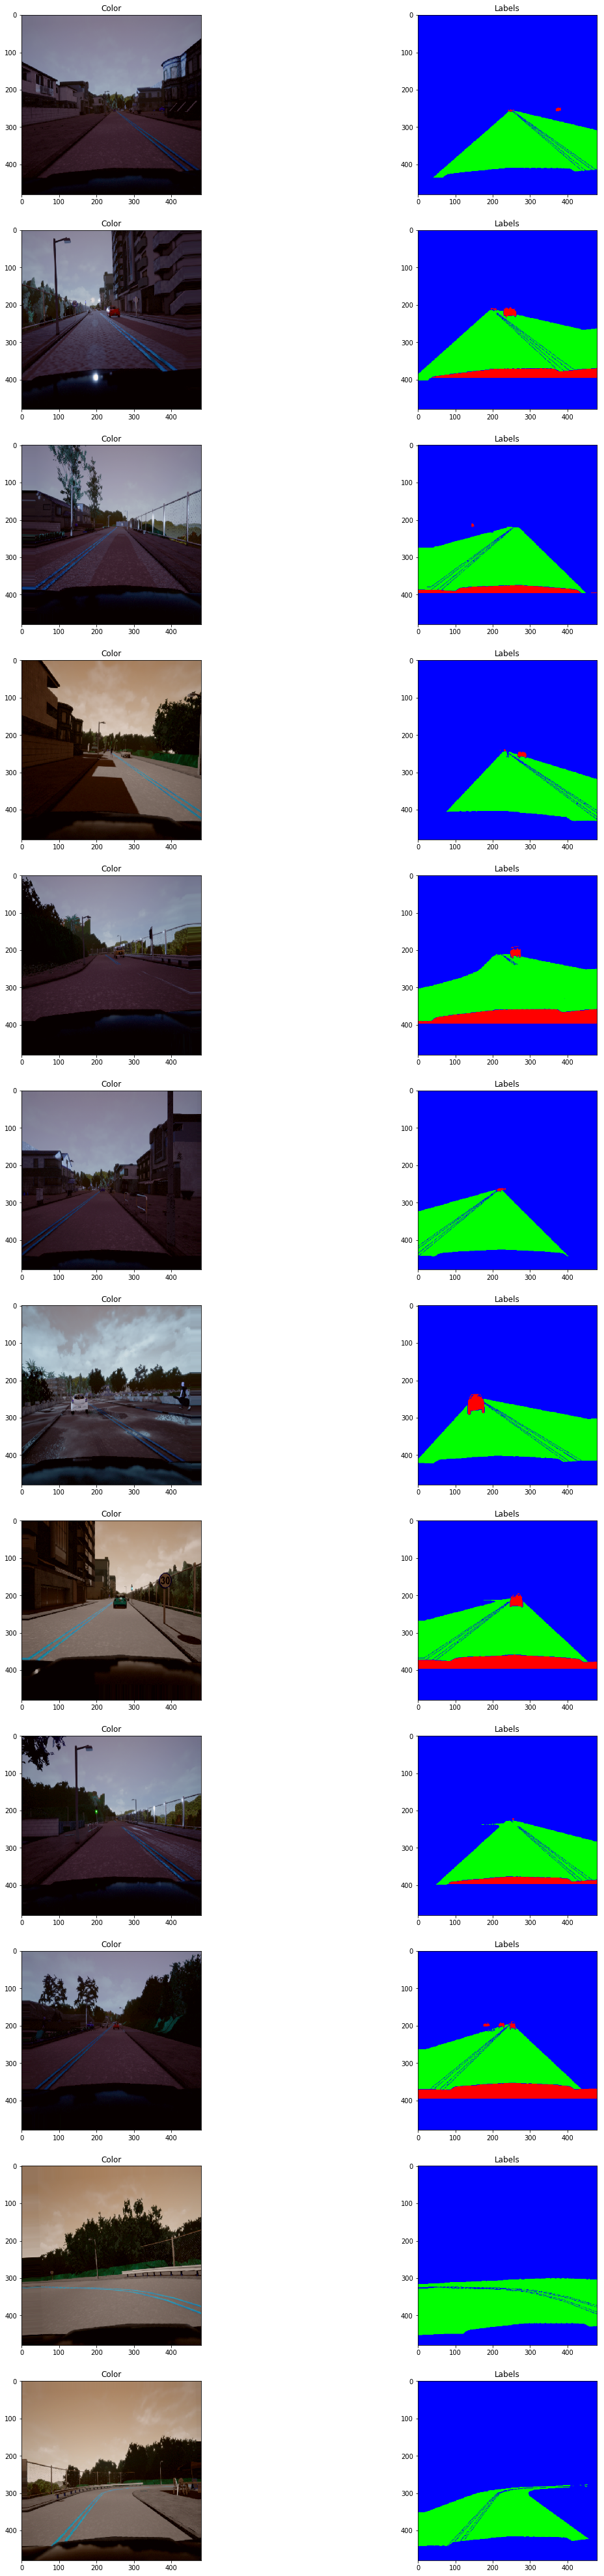

In [8]:
train_x, train_y = next(train_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, train_x, train_y):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [9]:
X = np.expand_dims(train_x[6], 0)
Y = np.expand_dims(train_y[6], 0)
print (X.shape, Y.shape)

# model.reset_states()
model.fit(X, Y, epochs=500)

(1, 480, 480, 3) (1, 480, 480, 3)
Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 19.8757 - acc: 0.3251
Epoch 2/500
1/1 [==============================] - 0s 166ms/step - loss: 19.3800 - acc: 0.3347
Epoch 3/500
1/1 [==============================] - 0s 167ms/step - loss: 18.8687 - acc: 0.3445
Epoch 4/500
1/1 [==============================] - 0s 163ms/step - loss: 18.3737 - acc: 0.3545
Epoch 5/500
1/1 [==============================] - 0s 165ms/step - loss: 17.8688 - acc: 0.3638
Epoch 6/500
1/1 [==============================] - 0s 172ms/step - loss: 17.4005 - acc: 0.3726
Epoch 7/500
1/1 [==============================] - 0s 164ms/step - loss: 16.8978 - acc: 0.3812
Epoch 8/500
1/1 [==============================] - 0s 170ms/step - loss: 16.4363 - acc: 0.3887
Epoch 9/500
1/1 [==============================] - 0s 163ms/step - loss: 15.9785 - acc: 0.3955
Epoch 10/500
1/1 [==============================] - 0s 167ms/step - loss: 15.5536 - acc: 0.4008
Epoch 11/500
1/1 [

Epoch 87/500
1/1 [==============================] - 0s 172ms/step - loss: 1.0999 - acc: 0.9590
Epoch 88/500
1/1 [==============================] - 0s 165ms/step - loss: 1.0775 - acc: 0.9596
Epoch 89/500
1/1 [==============================] - 0s 168ms/step - loss: 1.0523 - acc: 0.9575
Epoch 90/500
1/1 [==============================] - 0s 167ms/step - loss: 1.0295 - acc: 0.9572
Epoch 91/500
1/1 [==============================] - 0s 167ms/step - loss: 0.9943 - acc: 0.9576
Epoch 92/500
1/1 [==============================] - 0s 171ms/step - loss: 0.9720 - acc: 0.9587
Epoch 93/500
1/1 [==============================] - 0s 168ms/step - loss: 0.9570 - acc: 0.9604
Epoch 94/500
1/1 [==============================] - 0s 173ms/step - loss: 0.9162 - acc: 0.9597
Epoch 95/500
1/1 [==============================] - 0s 165ms/step - loss: 0.8887 - acc: 0.9606
Epoch 96/500
1/1 [==============================] - 0s 163ms/step - loss: 0.8773 - acc: 0.9624
Epoch 97/500
1/1 [==============================] 

Epoch 173/500
1/1 [==============================] - 0s 165ms/step - loss: 0.4152 - acc: 0.9827
Epoch 174/500
1/1 [==============================] - 0s 164ms/step - loss: 0.4218 - acc: 0.9829
Epoch 175/500
1/1 [==============================] - 0s 168ms/step - loss: 0.3862 - acc: 0.9830
Epoch 176/500
1/1 [==============================] - 0s 175ms/step - loss: 0.3972 - acc: 0.9820
Epoch 177/500
1/1 [==============================] - 0s 174ms/step - loss: 0.4253 - acc: 0.9805
Epoch 178/500
1/1 [==============================] - 0s 165ms/step - loss: 0.4102 - acc: 0.9804
Epoch 179/500
1/1 [==============================] - 0s 166ms/step - loss: 0.4106 - acc: 0.9809
Epoch 180/500
1/1 [==============================] - 0s 173ms/step - loss: 0.4056 - acc: 0.9810
Epoch 181/500
1/1 [==============================] - 0s 168ms/step - loss: 0.4200 - acc: 0.9829
Epoch 182/500
1/1 [==============================] - 0s 166ms/step - loss: 0.3910 - acc: 0.9832
Epoch 183/500
1/1 [=====================

Epoch 259/500
1/1 [==============================] - 0s 165ms/step - loss: 0.3444 - acc: 0.9859
Epoch 260/500
1/1 [==============================] - 0s 165ms/step - loss: 0.3310 - acc: 0.9858
Epoch 261/500
1/1 [==============================] - 0s 164ms/step - loss: 0.3258 - acc: 0.9850
Epoch 262/500
1/1 [==============================] - 0s 177ms/step - loss: 0.3296 - acc: 0.9848
Epoch 263/500
1/1 [==============================] - 0s 172ms/step - loss: 0.3284 - acc: 0.9841
Epoch 264/500
1/1 [==============================] - 0s 168ms/step - loss: 0.3237 - acc: 0.9842
Epoch 265/500
1/1 [==============================] - 0s 172ms/step - loss: 0.3235 - acc: 0.9847
Epoch 266/500
1/1 [==============================] - 0s 168ms/step - loss: 0.3051 - acc: 0.9855
Epoch 267/500
1/1 [==============================] - 0s 166ms/step - loss: 0.3314 - acc: 0.9861
Epoch 268/500
1/1 [==============================] - 0s 166ms/step - loss: 0.3119 - acc: 0.9860
Epoch 269/500
1/1 [=====================

Epoch 345/500
1/1 [==============================] - 0s 167ms/step - loss: 0.2718 - acc: 0.9867
Epoch 346/500
1/1 [==============================] - 0s 167ms/step - loss: 0.2659 - acc: 0.9872
Epoch 347/500
1/1 [==============================] - 0s 169ms/step - loss: 0.2650 - acc: 0.9879
Epoch 348/500
1/1 [==============================] - 0s 175ms/step - loss: 0.2637 - acc: 0.9872
Epoch 349/500
1/1 [==============================] - 0s 163ms/step - loss: 0.2648 - acc: 0.9876
Epoch 350/500
1/1 [==============================] - 0s 166ms/step - loss: 0.2739 - acc: 0.9869
Epoch 351/500
1/1 [==============================] - 0s 174ms/step - loss: 0.2901 - acc: 0.9871
Epoch 352/500
1/1 [==============================] - 0s 166ms/step - loss: 0.2977 - acc: 0.9867
Epoch 353/500
1/1 [==============================] - 0s 165ms/step - loss: 0.2602 - acc: 0.9878
Epoch 354/500
1/1 [==============================] - 0s 165ms/step - loss: 0.2678 - acc: 0.9875
Epoch 355/500
1/1 [=====================

Epoch 431/500
1/1 [==============================] - 0s 167ms/step - loss: 0.2306 - acc: 0.9886
Epoch 432/500
1/1 [==============================] - 0s 170ms/step - loss: 0.2483 - acc: 0.9880
Epoch 433/500
1/1 [==============================] - 0s 167ms/step - loss: 0.2327 - acc: 0.9884
Epoch 434/500
1/1 [==============================] - 0s 173ms/step - loss: 0.2425 - acc: 0.9885
Epoch 435/500
1/1 [==============================] - 0s 169ms/step - loss: 0.2231 - acc: 0.9894
Epoch 436/500
1/1 [==============================] - 0s 173ms/step - loss: 0.2321 - acc: 0.9892
Epoch 437/500
1/1 [==============================] - 0s 166ms/step - loss: 0.2305 - acc: 0.9892
Epoch 438/500
1/1 [==============================] - 0s 167ms/step - loss: 0.2250 - acc: 0.9887
Epoch 439/500
1/1 [==============================] - 0s 165ms/step - loss: 0.2427 - acc: 0.9872
Epoch 440/500
1/1 [==============================] - 0s 167ms/step - loss: 0.2347 - acc: 0.9881
Epoch 441/500
1/1 [=====================

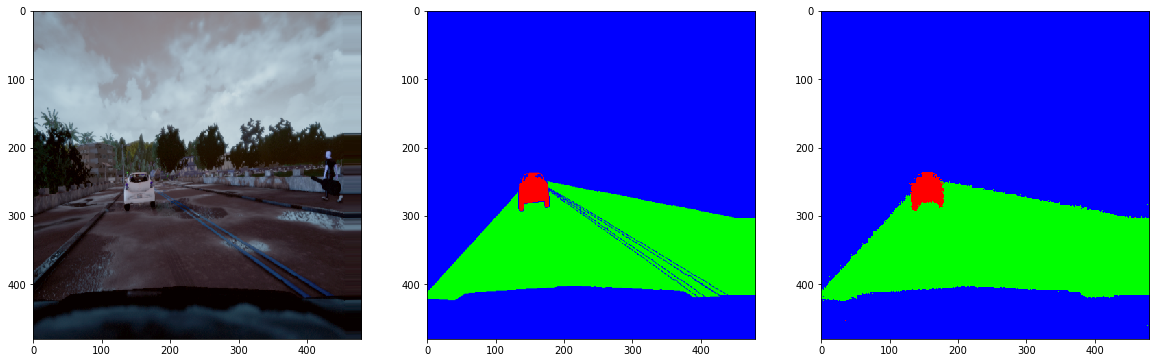

In [10]:
pred = model.predict(X)
pred = pred[0].argmax(axis=2)
pred_out = np.zeros_like(Y[0])
pred_out[:, :, 0] = pred == 0
pred_out[:, :, 1] = pred == 1
pred_out[:, :, 2] = pred == 2

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(np.clip(X[0]+110, 0, 255).astype(np.uint8))
plt.subplot(132)
plt.imshow(Y[0])
plt.subplot(133)
plt.imshow(pred_out)

In [ ]:

from train import jaccard_distance_loss
from keras.utils.training_utils import multi_gpu_model

gpus = 2

model_gpu = multi_gpu_model(model, gpus)

model_gpu.compile(optimizer = 'adam', 
                   loss = jaccard_distance_loss, 
                   metrics = ['acc', 'categorical_accuracy'])


In [ ]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=100,
                  gpus = 2)

In [ ]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('{}/model_saved.h5'.format(model_dir))